# Imports

In [1]:
import numpy as np
import pandas as pd # only used for loading and saving data
import matplotlib.pyplot as plt # only used for plotting trainig stats

# Data

## Loading

In [2]:
DATA_PATH = "titanic/"

In [3]:
test_set = pd.read_csv(DATA_PATH + "test.csv")
training_set = pd.read_csv(DATA_PATH + "train.csv")

## Viewing

In [4]:
training_set.shape

(891, 12)

In [5]:
test_set.shape

(418, 11)

In [6]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Processing

In [8]:
def convert_dataset(data_set, drop=[]):
    # Drops unwanted columns, creates dummies for non-numeric data, converts to float64
    
    _data_set = data_set.copy()
    return pd.get_dummies(_data_set.drop(drop, axis=1)).astype('float64')

In [9]:
# I am dropping the columns that don't have the same domain across training and test sets.
# I now this isn't necessary but I didn't have more time to spare on pre-processing.
training_set = convert_dataset(data_set=training_set, drop=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"])
observations = training_set.drop("Survived", axis=1).fillna(-1).values
outcomes = training_set["Survived"].values

# Model

## Functions

In [10]:
# Defining the sigmoid and the log-loss functions

def sigmoid(x, d=False):
    if d:
        return np.multiply(x, (1-x))
    return (1 / (1 + np.exp(-x)).astype(float))

def log_loss(yHat, y):
    if y == 1:
        return -np.log(yHat)
    return -np.log(1-yHat)


In [11]:
# Defining the neural network class

class nn:
    def __init__(
        self, 
        observations, 
        outcomes, 
        activation_function, 
        loss_function, 
        sigmoid, 
        epochs = 5000, 
        learning_rate = 0.1
    ):
        # Training data
        self.observations = observations
        self.outcomes = outcomes
        
        # Functions
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.sigmoid = sigmoid
        
        # Parameters
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        # Weights
        self.W1 = np.random.randn(10, observations.shape[-1])
        self.W2 = np.random.randn(1, 10)
        
        # Statistics
        self.current_loss = float("inf")
        self.stats = []
        
    def forward(self, x):
        # Forward propagation. Returns output and hidden layer for later backpropagation.
        
        hidden = self.activation_function(np.dot(self.W1, x))
        output = self.sigmoid(np.dot(self.W2, hidden))
        
        return output, hidden
            
    def backward(self, x, h, yHat, y, l):
        # Backpropagation. Takes the observation, hidden layer, prediction, actual value, 
        # and loss and updates the weights.
        
        # x and h need to be 2d.
        x = np.reshape(x, (1, -1))
        h = np.reshape(h, (1, -1))
        
        # d=True in sigmoid returns derivative.
        d = self.learning_rate * l * self.sigmoid(yHat, d=True) 
        d = np.reshape(d, (-1, 1))
        
        # 2 * (y-0.5) ensures weights are updated in the right direction (positive vs. negative)
        self.W2 += (np.dot(d, h) * 2 * (y-0.5))
        
        # d=True in activation_function returns derivative.
        d = np.dot(d, self.W2) * self.activation_function(h, d=True)
        d = d.reshape(10, 1)
        
        # 2 * (y-0.5) ensures weights are updated in the right direction (positive vs. negative)
        self.W1 += (np.dot(d, x) * 2 * (y-0.5))
        
    def train(self, print_stats=False):
        # Training the model. Loops over the epochs and then over the training set.
        
        print("Training started")
        
        for i in range(self.epochs+1):
            self.current_loss = 0
            for x, y in zip(self.observations, self.outcomes):
                
                yHat, h = self.forward(x)
                l = self.loss_function(yHat, y)
                self.current_loss += np.absolute(l)
                self.backward(x, h, yHat, y, l)
                
            if i%100==0:
                # Printing and saving statistics to check model performance. Also updates learning rate.
                
                accuracy = round(self.calculate_accuracy(self.observations, self.outcomes), 2)
                stats = (
                    i, 
                    self.current_loss[0]/float(len(self.observations)), 
                    accuracy, 
                    self.learning_rate
                )
                self.stats.append(stats)
                self.learning_rate *= 0.9
                
                print("{}%".format(100*i/self.epochs))
                
                if print_stats:
                    print("epoch: {}\nloss: {}\naccuracy: {}%".format(
                        stats[0],
                        stats[1],
                        stats[2]
                    ))
                    
        print("Training finished")
        
    def predict(self, x):
        # Function to predict test set later on
        
        prediction, _ = self.forward(x)
        return prediction
    
    def calculate_accuracy(self, X, Y):
        # calculating the accuracy of the current model using training data
        
        correct = 0
        incorrect = 0
        
        for x, y in zip(X, Y):
            if round(self.forward(x)[0][0]) == y:
                correct += 1
            else:
                incorrect += 1
                
        return (100*correct/(correct+incorrect))
    

## Initialization

Initializing the network with the sigmoid function as activation function and log-loss as loss function.

In [12]:
np.random.seed(1)
network = nn(observations, outcomes, sigmoid, log_loss, sigmoid)

## Training

In [13]:
network.train(print_stats=True)

Training started
0.0%
epoch: 0
loss: 0.6494318603401127
accuracy: 65.43%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


2.0%
epoch: 100
loss: 0.6070845182110128
accuracy: 69.36%
4.0%
epoch: 200
loss: 0.5784451379240823
accuracy: 70.48%
6.0%
epoch: 300
loss: 0.5729307384765372
accuracy: 70.03%
8.0%
epoch: 400
loss: 0.6017968749043668
accuracy: 68.91%
10.0%
epoch: 500
loss: 0.5986014974223737
accuracy: 68.8%
12.0%
epoch: 600
loss: 0.5971611182024597
accuracy: 68.8%
14.0%
epoch: 700
loss: 0.5959687924844868
accuracy: 69.02%
16.0%
epoch: 800
loss: 0.5953934775829768
accuracy: 68.91%
18.0%
epoch: 900
loss: 0.5945497757458805
accuracy: 69.25%
20.0%
epoch: 1000
loss: 0.5913240146637496
accuracy: 69.02%
22.0%
epoch: 1100
loss: 0.5259769588768539
accuracy: 77.78%
24.0%
epoch: 1200
loss: 0.5025431471216744
accuracy: 75.31%
26.0%
epoch: 1300
loss: 0.5111047257578766
accuracy: 79.69%
28.0%
epoch: 1400
loss: 0.49264364797747684
accuracy: 75.2%
30.0%
epoch: 1500
loss: 0.5020544173838448
accuracy: 80.58%
32.0%
epoch: 1600
loss: 0.4766721794422097
accuracy: 80.58%
34.0%
epoch: 1700
loss: 0.47105548609406805
accuracy: 8

# Statistics

In [14]:
epochs = [x[0] for x in network.stats]
loss = [x[1] for x in network.stats]
accuracy = [x[2] for x in network.stats]
learning_rate = [x[3] for x in network.stats]

## Training loss

Loss decreases with initial jumps until it flattens out around an average loss of 0.45 after about 2,500 epochs.

Text(0.5,1,'Average log loss during training')

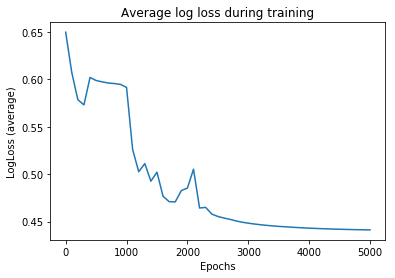

In [15]:
plt.plot(epochs, loss)
plt.xlabel('Epochs')
plt.ylabel('LogLoss (average)')
plt.title('Average log loss during training')

## Training accuracy

Accuracy increases, with large jumps during the first 2,000 epochs. Flattens out and stays consistent after 2,000 epochs.

Text(0.5,1,'Training accuracy')

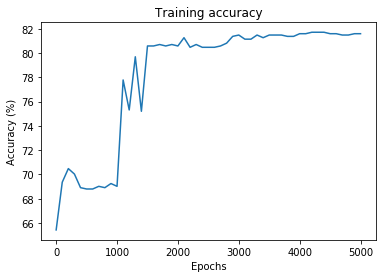

In [16]:
plt.plot(epochs, accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training accuracy')

## Learning rate

I am multiplying the learning rate by 0.9 every 100 epochs to make sure that training converges to a minimum.

Text(0.5,1,'Learning rate during training')

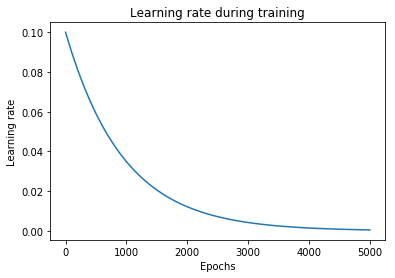

In [17]:
plt.plot(epochs, learning_rate)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.title('Learning rate during training')

# Result

In [18]:
test_observations = convert_dataset(
    data_set=test_set, 
    drop=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"]
).fillna(-1).values

## Predictions

In [19]:
predictions = []
for row in test_observations:
    predictions.append(int(np.round(network.predict(row))[0]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


## Submission

I submitted three different versions, training the model for 1,000, 5,000, and 10,000 epochs respectively. As can be expected, the test accuracy is lower than the training accuracy, which suggests slight overfitting. Notably, training the model for 5,000 epochs significantly improved test accuracy over 1,000 epochs, but beyond that there was no improvement in 10,000 epochs. Below you can see a screenshot of my submissions on kaggle:

In [20]:
submission = pd.DataFrame({"PassengerId": test_set["PassengerId"], "Survived": predictions}, index=None)
submission.to_csv("np_nn_submission.csv", index=False)

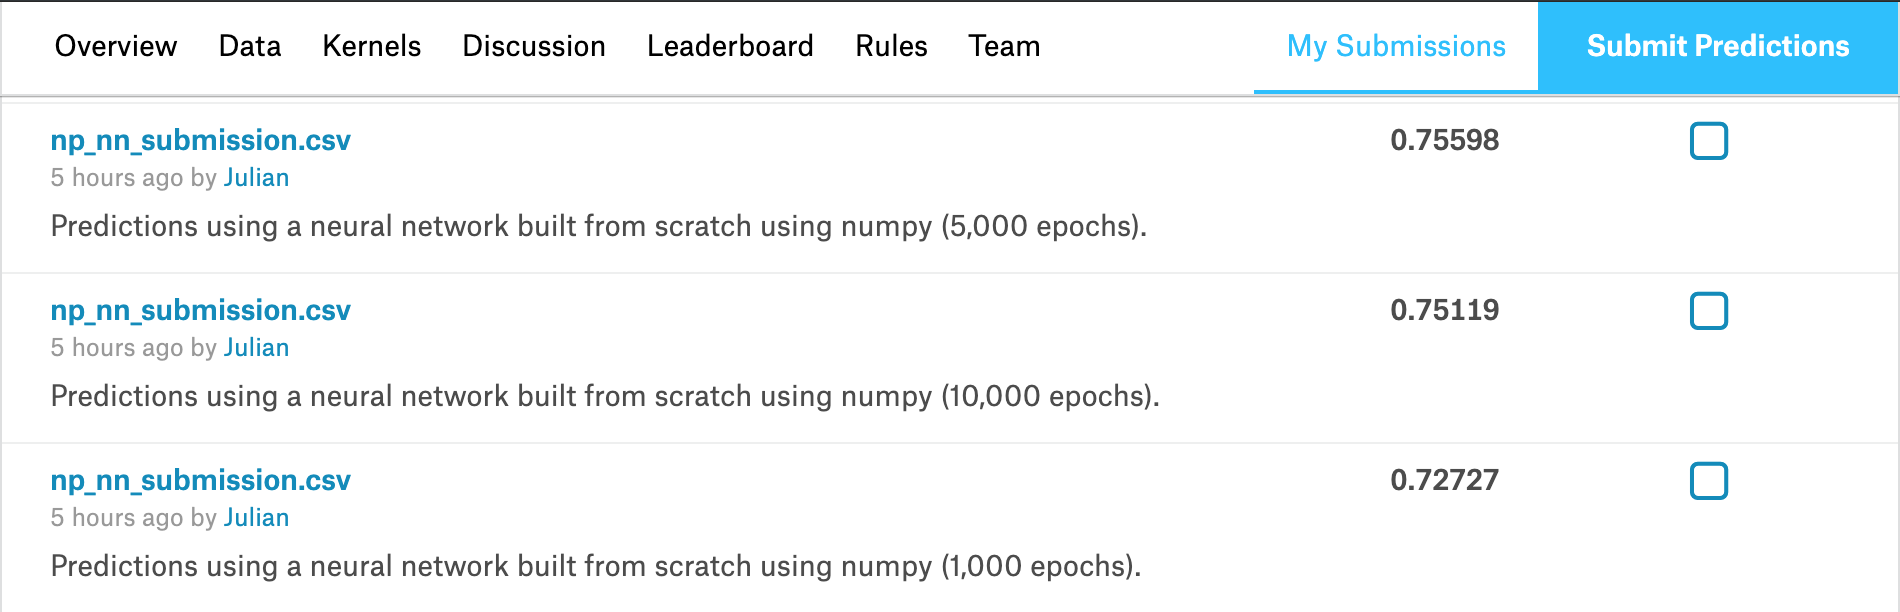

In [21]:
from IPython.display import Image
Image("np_nn_submission.png")